In [1]:
import torch
import importlib

Player Input

In [2]:
import Player_Prep
importlib.reload(Player_Prep)
from Player_Prep import Generate_Hitters, Generate_Hitter_Mutators, Generate_Test_Train

In [3]:
fielding_components = 4
hitting_components = 5
stealing_components = 1
park_components = 2
person_components = 3
init_components = 3

input_size = fielding_components + hitting_components + stealing_components + park_components + person_components + init_components

In [4]:
hitter_input, hitter_output, (fielding_stddev,
                            hitting_stddev,
                            stealing_stddev,
                            park_stddev,
                            person_stddev), hitter_ids = Generate_Hitters(fielding_components,
                        hitting_components,
                        stealing_components,
                        park_components,
                        person_components)

Player Mutators

In [5]:
fielding_scale = 0.6
hitting_scale = 0.2
stealing_scale = 0.3
park_scale = 0.1
person_scale = 0.3
draft_scale = 0.2
signing_age_scale = 0.5

batch_size = 800
max_input_size = 79

In [6]:
hitting_mutators = Generate_Hitter_Mutators(batch_size, max_input_size,
                        fielding_components,fielding_scale,fielding_stddev,
                        hitting_components, hitting_scale, hitting_stddev,
                        stealing_components, stealing_scale, stealing_stddev,
                        park_components, park_scale, park_stddev,
                        person_components, person_scale, person_stddev,
                        draft_scale, signing_age_scale)

Test/Train Split

In [7]:
import Dataset
importlib.reload(Dataset)
from Dataset import HitterDataset

In [8]:
test_size = 0.2
random_state = 1

x_train_padded, x_test_padded, y_train_padded, y_test_padded, train_lengths, test_lengths = Generate_Test_Train(
    hitter_input, hitter_output, test_size, random_state)

train_hitters_dataset = HitterDataset(x_train_padded, train_lengths, y_train_padded)
test_hitters_dataset = HitterDataset(x_test_padded, test_lengths, y_test_padded)

In [9]:
print(y_train_padded.shape)
print(hitter_output[0].shape)

torch.Size([73, 8720, 3])
torch.Size([22, 3])


Train Model

In [10]:
import Model
import Constants
import Model_Train
from torch.optim import lr_scheduler

importlib.reload(Model)
importlib.reload(Constants)
importlib.reload(Model_Train)

from Model import RNN_Model, LSTM_Model, RNN_Classification_Loss
from Constants import device
from Model_Train import trainAndGraph

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 10671
Epoch [1/1000], Train Loss: 2.9793, Test Loss: 2.0355
Epoch [11/1000], Train Loss: 0.6546, Test Loss: 0.6503
Epoch [21/1000], Train Loss: 0.6623, Test Loss: 0.6297
Epoch [31/1000], Train Loss: 0.5330, Test Loss: 0.5250
Epoch [41/1000], Train Loss: 0.5217, Test Loss: 0.5159
Epoch [51/1000], Train Loss: 0.5154, Test Loss: 0.5145
Epoch [61/1000], Train Loss: 0.5127, Test Loss: 0.5090
Epoch [71/1000], Train Loss: 0.4984, Test Loss: 0.4950
Epoch [81/1000], Train Loss: 0.4884, Test Loss: 0.4901
Epoch [91/1000], Train Loss: 0.4827, Test Loss: 0.4861
Epoch [101/1000], Train Loss: 0.4810, Test Loss: 0.4875
Epoch [111/1000], Train Loss: 0.4750, Test Loss: 0.4844
Epoch [121/1000], Train Loss: 0.4706, Test Loss: 0.4889
Epoch [131/1000], Train Loss: 0.4647, Test Loss: 0.4883
Stopped Training Early
Best result at epoch=98 with loss=0.4826647142569224


0.4826647142569224

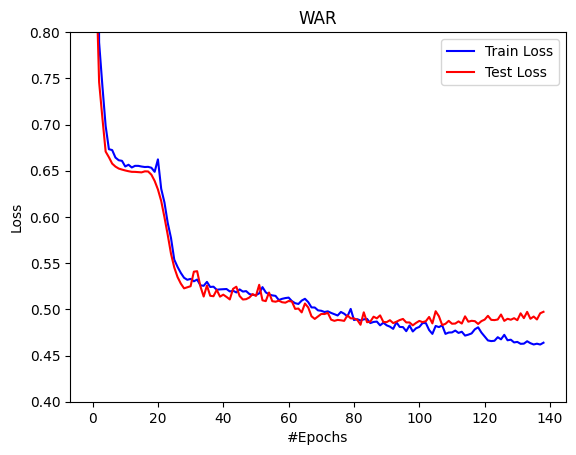

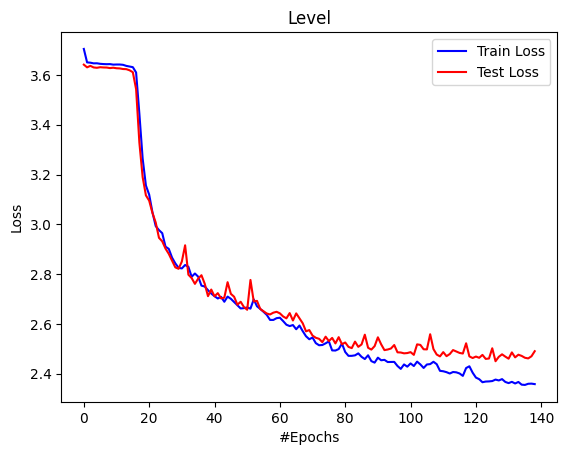

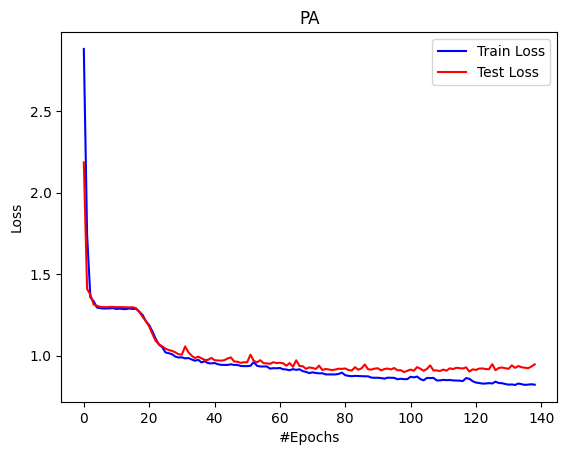

In [20]:
dropout_perc = 0.0
num_layers = 5
hidden_size = 30
network = RNN_Model(input_size, num_layers, hidden_size, dropout_perc, hitting_mutators)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = RNN_Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_hitters_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_hitters_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.4,0.8)
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, 10, early_stopping_cutoff=40, should_output=True, graph_y_range=graph_y_range)

Sanity Check

Check what model things of certain players

In [13]:
import torch.nn.functional as F
importlib.reload(Dataset)
from Dataset import WAR_BUCKETS, LEVEL_BUCKETS, PA_BUCKETS

In [14]:
paddedHitterInput = torch.nn.utils.rnn.pad_sequence(hitter_input)
hitterLengths = torch.tensor([len(seq) for seq in hitter_input])
network.load_state_dict(torch.load("best_model.pt"))
network.eval()
network = network.to(device)

def GetPlayer(name, id, stat):
    with torch.no_grad():
        for i, hitter in enumerate(hitter_ids):
            if hitter == id:
                idx = i
                break
            
        input = paddedHitterInput[:,idx,:].unsqueeze(0).clone()
        # input[:,:,1] = (input[0,0,1] - pickMean) / pickStd
        output_war, output_level, output_pa = network(input.to(device), hitterLengths[idx].unsqueeze(0).to(device))

        print(name)
        torch.set_printoptions(precision=2, sci_mode=False, linewidth=1000)
        
        if stat == "WAR":
            print("WAR")
            print(F.softmax(output_war.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(hitter_output[idx][0][0].item())
            print(torch.bucketize(hitter_output[idx][0][0], WAR_BUCKETS).cpu().item())
        elif stat == "Level":
            print("Level")
            print(F.softmax(output_level.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(hitter_output[idx][0][1].item())
            print(torch.bucketize(hitter_output[idx][0][1], LEVEL_BUCKETS).cpu().item())
        
        elif stat == "PA":
            print("PA")
            print(F.softmax(output_pa.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(hitter_output[idx][0][2].item())
            print(torch.bucketize(hitter_output[idx][0][2], PA_BUCKETS).cpu().item())

In [15]:
stat = "WAR"
GetPlayer("Michael Harrington", 518769, stat)
GetPlayer("Mike Trout", 545361, stat)
GetPlayer("Levi Michael", 605381, stat)
GetPlayer("Bryce Harper", 547180, stat)
GetPlayer("Mike Moustakas", 519058, stat)
GetPlayer("Max Kepler", 596146, stat)
GetPlayer("Jose Altuve", 514888, stat)
GetPlayer("Danny Santana", 542454, stat)

Michael Harrington
WAR
tensor([[    0.91,     0.04,     0.02,     0.02,     0.01,     0.00,     0.00],
        [    0.98,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.98,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99

Save Model Results for Players

In [16]:
import Output
importlib.reload(Constants)
importlib.reload(Player_Prep)
importlib.reload(Output)
from Output import Delete_Model_Run_Hitter, Generate_Model_Run_Hitter
from Constants import db

In [17]:
cursor = db.cursor()
all_hitter_ids = cursor.execute("SELECT mlbId FROM Model_Players WHERE isHitter='1'").fetchall()

In [18]:
# model = "test_run_hitters"
# Delete_Model_Run_Hitter(model)
# Generate_Model_Run_Hitter(model, all_hitter_ids, hitter_ids, network, device, leave_progress=True)